In [ ]:
!pip install -q transformers scikit-learn accelerate matplotlib

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# ---------------------------
# UNIFIED TRAINER CLASS
# ---------------------------
class PolarizationTrainer:
    def __init__(
        self,
        csv_path,
        task="task2",
        model_names=["bert-large-uncased"],  # list of models for ensemble
        criterion="focal",
        early_stop=True,
        patience=2,
        max_epochs=10,
        #ensemble=False,
        test_csv_path=None,
        load_only=False,                      # If True, we load the already trained model, no training.

    ):
        self.csv_path = csv_path
        self.task = task
        self.model_names = model_names
        self.criterion = criterion
        self.early_stop = early_stop
        self.patience = patience
        self.max_epochs = max_epochs
        #self.ensemble = ensemble
        self.test_csv_path = test_csv_path
        self.test_df = None
        self.load_only = load_only
        if test_csv_path is not None:
            self.test_df = pd.read_csv(test_csv_path)


        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:", self.device)

        self.df = pd.read_csv(csv_path)
        # self.label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
        # if self.task=="task1":
        #     self.df["polarized"] = (self.df[self.label_cols].sum(axis=1) > 0).astype(int)

        if self.task == "task1":
            self.label_cols = ["polarization"]   # single binary label
        else:
            self.label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

        self._prepare_data()

    # ---------------------------
    # DATASET
    # ---------------------------
    class PolarizationDataset(torch.utils.data.Dataset):
        def __init__(self, texts, labels, tokenizer, multilabel=False, max_length=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.multilabel = multilabel
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            encoding = self.tokenizer(
                self.texts[idx],
                truncation=True,
                padding=False,
                max_length=self.max_length,
                return_tensors="pt"
            )
            item = {k: v.squeeze(0) for k, v in encoding.items()}
            dtype = torch.float if self.multilabel else torch.long
            label = torch.tensor(self.labels[idx], dtype=dtype)
            # If single output and not multilabel, add a dimension
            if not self.multilabel and label.ndim == 0:
                label = label.unsqueeze(0)

            item["labels"] = label
            return item

    # ---------------------------
    # DATA PREP
    # ---------------------------
    def _prepare_data(self):
        # if self.task=="task1":
        #     self.num_labels = 1
        #     self.train_df, self.val_df = train_test_split(
        #         self.df, test_size=0.15, random_state=42, stratify=self.df["polarized"]
        #     )
        #     #self.num_labels = 2
        #     self.problem_type = None
        if self.task == "task1":
            self.num_labels = 1
            self.train_df, self.val_df = train_test_split(
                self.df,
                test_size=0.15,
                random_state=42,
                stratify=self.df["polarization"]
            )
            self.problem_type = None

        else:
            self.train_df, self.val_df = train_test_split(self.df, test_size=0.15, random_state=42)
            self.num_labels = len(self.label_cols)                                                   # multi label, header based
            self.problem_type = "multi_label_classification"

    def _compute_class_weights(self, labels):
        labels_tensor = torch.tensor(labels)
        counts = labels_tensor.sum(dim=0)
        total = labels_tensor.size(0)
        counts = torch.clamp(counts, min=1.0)
        weights = total / counts
        weights = weights / weights.mean()
        return weights.to(self.device)

    # ---------------------------
    # CUSTOM MODEL + CRITERION
    # ---------------------------
    class FocalLoss(nn.Module):
        def __init__(self, alpha, gamma=2.0):
            super().__init__()
            self.alpha = alpha                      # class weights
            self.gamma = gamma

        def forward(self, logits, targets):
            bce = nn.BCEWithLogitsLoss(pos_weight=self.alpha, reduction="none")
            bce_loss = bce(logits, targets)
            probs = torch.sigmoid(logits)
            pt = targets*probs + (1-targets)*(1-probs)
            focal_weight = (1 - pt) ** self.gamma
            return (focal_weight * bce_loss).mean()

    class WeightedModel(nn.Module):
        def __init__(self, model_name, num_labels, class_weights=None, problem_type=None, criterion="focal"):
            super().__init__()
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name,
                num_labels=num_labels,
                problem_type=problem_type
            )
            self.class_weights = class_weights
            self.criterion_type = criterion

        def forward(self, input_ids=None, attention_mask=None, labels=None):
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = None
            if labels is not None:
                if self.criterion_type=="bce":
                    criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)
                else:
                    criterion = PolarizationTrainer.FocalLoss(alpha=self.class_weights)
                loss = criterion(logits, labels.float())
            return {"loss": loss, "logits": logits}

    # ---------------------------
    # METRICS
    # ---------------------------
    def compute_metrics(self, p):
      logits = p.predictions
      if isinstance(logits, tuple):
          logits = logits[0]
      if logits.shape[1] == 1:  # Task1 single logit
          probs = torch.sigmoid(torch.tensor(logits)).squeeze(-1)
          preds = (probs > 0.5).int().numpy()
      else:
          probs = torch.sigmoid(torch.tensor(logits))
          preds = (probs > 0.5).int().numpy()
      return {"f1_macro": f1_score(p.label_ids, preds, average="macro")}


    # ---------------------------
    # TRAIN SINGLE MODEL
    # ---------------------------
    def _train_model(self, model_name):

        if self.load_only:
            model_path = f"./saved_models/{model_name}_{self.task}"
            print(f"\nLoading pretrained model from {model_path}")
            tokenizer = AutoTokenizer.from_pretrained(model_path)

            model = self.WeightedModel(
                model_name=model_path,
                num_labels=self.num_labels,
                class_weights=None,          # NOT needed for inference
                problem_type=self.problem_type,
                criterion=self.criterion
            )

            trainer = Trainer(
                model=model,
                args=TrainingArguments(
                    output_dir="./tmp",
                    per_device_eval_batch_size=8
                ),
                compute_metrics=self.compute_metrics,
                data_collator=DataCollatorWithPadding(tokenizer)
            )

            return trainer, None

        print(f"\nTraining {model_name} for {self.task}...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        if self.task=="task1":
            train_ds = self.PolarizationDataset(self.train_df["text"].tolist(), self.train_df["polarization"].tolist(), tokenizer, multilabel=False)
            val_ds = self.PolarizationDataset(self.val_df["text"].tolist(), self.val_df["polarization"].tolist(), tokenizer, multilabel=False)
        else:
            train_ds = self.PolarizationDataset(self.train_df["text"].tolist(), self.train_df[self.label_cols].values.tolist(), tokenizer, multilabel=True)
            val_ds = self.PolarizationDataset(self.val_df["text"].tolist(), self.val_df[self.label_cols].values.tolist(), tokenizer, multilabel=True)

        if self.task=="task2":
            class_weights = self._compute_class_weights(self.train_df[self.label_cols].values)
        else:
            class_weights = None

        model = self.WeightedModel(
            model_name, num_labels=self.num_labels, class_weights=class_weights,
            problem_type=self.problem_type, criterion=self.criterion
        )

        args = TrainingArguments(
            output_dir=f"./{self.task}_{model_name}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=8 if self.task=="task2" else 16,
            per_device_eval_batch_size=8 if self.task=="task2" else 16,
            num_train_epochs=self.max_epochs,
            logging_steps=50,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro"
        )

        callbacks = [EarlyStoppingCallback(early_stopping_patience=self.patience)] if self.early_stop else []

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=self.compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer),
            callbacks=callbacks
        )

        trainer.train()
        trainer.save_model(f"./saved_models/{model_name}_{self.task}")
        eval_res = trainer.evaluate()
        return trainer, eval_res

    # ---------------------------
    # ENSEMBLE PREDICTIONS
    # ---------------------------
    # def _ensemble_predict(self, trainers, val_ds):
    #     print("\nPerforming ensemble predictions...")
    #     all_logits = []
    #     for trainer in trainers:
    #         preds = trainer.predict(val_ds).predictions
    #         if isinstance(preds, tuple):
    #             preds = preds[0]
    #         all_logits.append(torch.sigmoid(torch.tensor(preds)))

    #     avg_logits = torch.stack(all_logits).mean(dim=0)
    #     if self.task=="task1":
    #         final_preds = (avg_logits > 0.5).int().numpy()
    #     else:
    #         final_preds = (avg_logits > 0.5).int().numpy()
    #     return final_preds


    # Test

    def _predict_on_df(self, trainer, df, tokenizer, multilabel):
        dataset = self.PolarizationDataset(
            df["text"].tolist(),
            df[self.label_cols].values.tolist() if multilabel else df["polarization"].tolist(),
            tokenizer,
            multilabel=multilabel
        )

        preds = trainer.predict(dataset).predictions
        if isinstance(preds, tuple):
            preds = preds[0]

        probs = torch.sigmoid(torch.tensor(preds))
        preds_bin = (probs > 0.5).int().numpy()
        return preds_bin

    # Plots

    def plot_results(self, trainers, eval_results, ensemble_preds=None):
        num_models = len(trainers)

        # Plot training curves for each model
        for i, trainer in enumerate(trainers):
            history = trainer.state.log_history
            train_loss = [x["loss"] for x in history if "loss" in x]
            eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
            f1_scores = [x["eval_f1_macro"] for x in history if "eval_f1_macro" in x]

            plt.figure(figsize=(12,5))
            plt.plot(train_loss, label="Train Loss", marker='o')
            plt.plot(eval_loss, label="Validation Loss", marker='s')
            plt.plot(f1_scores, label="F1 Macro", marker='^')
            plt.xlabel("Step")
            plt.ylabel("Value")
            plt.title(f"{self.task} - {self.model_names[i]}")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()
            plt.savefig(f"Train_val_loss_{self.task}_{self.model_names[i]}.png")

            # Confusion matrix / heatmap
            if self.task=="task1":
                val_labels = self.val_df["polarization"].values
            else:
                val_labels = self.val_df[self.label_cols].values
            preds = trainer.predict(trainer.eval_dataset).predictions
            if isinstance(preds, tuple):
                preds = preds[0]
            probs = torch.sigmoid(torch.tensor(preds))
            preds_bin = (probs > 0.5).int().numpy()

            if self.task=="task1":
                cm = confusion_matrix(val_labels, preds_bin)
                plt.figure(figsize=(6,5))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.title(f"{self.model_names[i]} - Confusion Matrix")
                plt.show()
            else:
                for j, col in enumerate(self.label_cols):
                    cm = confusion_matrix(val_labels[:,j], preds_bin[:,j])
                    plt.figure(figsize=(5,4))
                    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
                    plt.title(f"{self.model_names[i]} - {col} Confusion Matrix")
                    plt.xlabel("Predicted")
                    plt.ylabel("Actual")
                    plt.show()

        # Ensemble metrics & heatmap
        # if self.ensemble and ensemble_preds is not None:
        #     if self.task=="task1":
        #         val_labels = self.val_df["polarized"].values
        #     else:
        #         val_labels = self.val_df[self.label_cols].values
        #     final_preds = ensemble_preds

        #     # F1 Macro
        #     f1 = f1_score(val_labels, final_preds, average="macro")
        #     print(f"Ensemble F1 Macro: {f1:.4f}")

        #     if self.task=="task1":
        #         cm = confusion_matrix(val_labels, final_preds)
        #         plt.figure(figsize=(6,5))
        #         sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
        #         plt.xlabel("Predicted")
        #         plt.ylabel("Actual")
        #         plt.title("Ensemble Confusion Matrix")
        #         plt.show()
        #     else:
        #         for j, col in enumerate(self.label_cols):
        #             cm = confusion_matrix(val_labels[:,j], final_preds[:,j])
        #             plt.figure(figsize=(5,4))
        #             sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
        #             plt.title(f"Ensemble - {col} Confusion Matrix")
        #             plt.xlabel("Predicted")
        #             plt.ylabel("Actual")
        #             plt.show()

    # Plot test
    def plot_test_results(self):
        if self.test_df is None:
            print("No test set provided.")
            return

        print("\nEvaluating on TEST set...")

        multilabel = self.task == "task2"
        true_labels = (
            self.test_df[self.label_cols].values
            if multilabel else
            self.test_df["polarization"].values
        )

        for i, trainer in enumerate(self.trainers):
            tokenizer = AutoTokenizer.from_pretrained(self.model_names[i])
            preds = self._predict_on_df(trainer, self.test_df, tokenizer, multilabel)

            f1 = f1_score(true_labels, preds, average="macro")               # "Macro" averaging calculates the score for each category separately and then averages them.
            print(f"[TEST] {self.model_names[i]} F1 Macro: {f1:.4f}")

            if self.task == "task1":
                cm = confusion_matrix(true_labels, preds)
                plt.figure(figsize=(6,5))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
                plt.title(f"TEST – {self.model_names[i]}")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.show()
            else:
                for j, col in enumerate(self.label_cols):
                    cm = confusion_matrix(true_labels[:, j], preds[:, j])
                    plt.figure(figsize=(5,4))
                    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
                    plt.title(f"TEST – {self.model_names[i]} – {col}")
                    plt.xlabel("Predicted")
                    plt.ylabel("Actual")
                    plt.show()

        # ---------- ENSEMBLE ----------
        # if self.ensemble and len(self.trainers) > 1:
        #     all_preds = []
        #     tokenizer = AutoTokenizer.from_pretrained(self.model_names[0])

        #     test_ds = self.PolarizationDataset(
        #         self.test_df["text"].tolist(),
        #         true_labels.tolist(),
        #         tokenizer,
        #         multilabel=multilabel
        #     )

        #     for trainer in self.trainers:
        #         logits = trainer.predict(test_ds).predictions
        #         if isinstance(logits, tuple):
        #             logits = logits[0]
        #         all_preds.append(torch.sigmoid(torch.tensor(logits)))

        #     avg_logits = torch.stack(all_preds).mean(dim=0)
        #     ensemble_preds = (avg_logits > 0.5).int().numpy()

        #     f1 = f1_score(true_labels, ensemble_preds, average="macro")
        #     print(f"\n[TEST] ENSEMBLE F1 Macro: {f1:.4f}")

        #     if self.task == "task1":
        #         cm = confusion_matrix(true_labels, ensemble_preds)
        #         plt.figure(figsize=(6,5))
        #         sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
        #         plt.title("TEST – Ensemble")
        #         plt.xlabel("Predicted")
        #         plt.ylabel("Actual")
        #         plt.show()
        #     else:
        #         for j, col in enumerate(self.label_cols):
        #             cm = confusion_matrix(true_labels[:, j], ensemble_preds[:, j])
        #             plt.figure(figsize=(5,4))
        #             sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
        #             plt.title(f"TEST – Ensemble – {col}")
        #             plt.xlabel("Predicted")
        #             plt.ylabel("Actual")
        #             plt.show()




    # ---------------------------
    # MAIN RUN FUNCTION
    # ---------------------------
    def run(self):
        trainers = []
        eval_results = []

        for model_name in self.model_names:
            trainer, eval_res = self._train_model(model_name)
            trainers.append(trainer)
            eval_results.append(eval_res)

        # if self.ensemble and len(trainers) > 1:
        #     if self.task=="task1":
        #         val_ds = self.PolarizationDataset(self.val_df["text"].tolist(), self.val_df["polarized"].tolist(), AutoTokenizer.from_pretrained(self.model_names[0]))
        #     else:
        #         val_ds = self.PolarizationDataset(self.val_df["text"].tolist(), self.val_df[self.label_cols].values.tolist(), AutoTokenizer.from_pretrained(self.model_names[0]), multilabel=True)

        #     final_preds = self._ensemble_predict(trainers, val_ds)
        #     f1 = f1_score(self.val_df["polarized"] if self.task=="task1" else self.val_df[self.label_cols], final_preds, average="macro")
        #     print("final_preds.shape:", final_preds.shape)
        #     print("val_labels.shape:", self.val_df[self.label_cols].values.shape)
        #     print(f"\nEnsemble F1 Macro: {f1:.4f}")

        # ---- STORE EVERYTHING ----
        self.trainers = trainers
        self.eval_results = eval_results
        #self.ensemble_preds = final_preds
        #self.plot_results(trainers, eval_results, ensemble_preds=final_preds)
        self.plot_results(trainers, eval_results, ensemble_preds=None)
        if self.test_df is not None:
            self.plot_test_results()


        # # Plot training curves for the first model
        # history = trainers[0].state.log_history
        # train_loss = [x["loss"] for x in history if "loss" in x]
        # eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
        # f1_scores = [x["eval_f1_macro"] for x in history if "eval_f1_macro" in x]

        # plt.figure(figsize=(10,5))
        # plt.plot(train_loss, label="Train Loss")
        # plt.plot(eval_loss, label="Validation Loss")
        # plt.plot(f1_scores, label="F1 Macro")
        # plt.xlabel("Step")
        # plt.ylabel("Value")
        # plt.legend()
        # plt.title(f"{self.task} - {self.model_names[0]}")
        # plt.show()

        return trainers, eval_results




Device: cuda

Training bert-large-uncased for task2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.045200,0.039022,0.031367
2,0.032700,0.042098,0.290227
3,0.023300,0.058624,0.212677
4,0.011300,0.064476,0.298863
5,0.007000,0.073643,0.335827
6,0.002900,0.088930,0.293908
7,0.002200,0.091807,0.328119



Training roberta-large for task2...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.047100,0.047421,0.000000
2,0.038100,0.045453,0.343290
3,0.034700,0.043885,0.330927
4,0.023500,0.048955,0.362718
5,0.020800,0.059729,0.460892
6,0.010200,0.075968,0.445223
7,0.006800,0.080259,0.464292


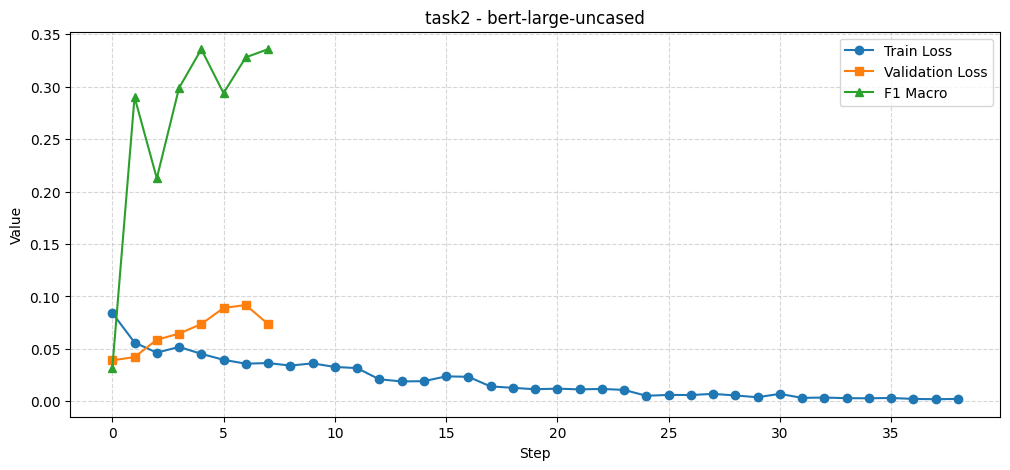

<Figure size 640x480 with 0 Axes>

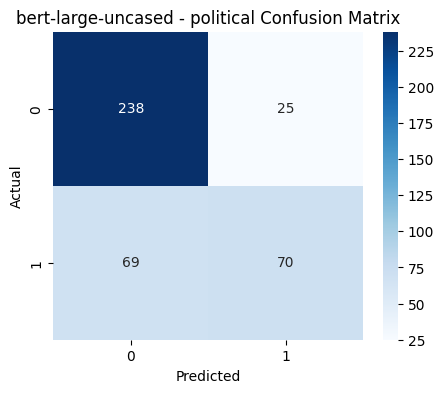

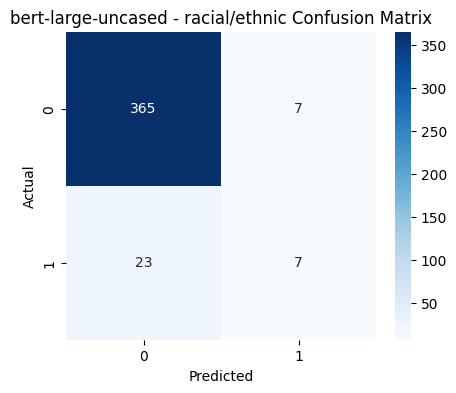

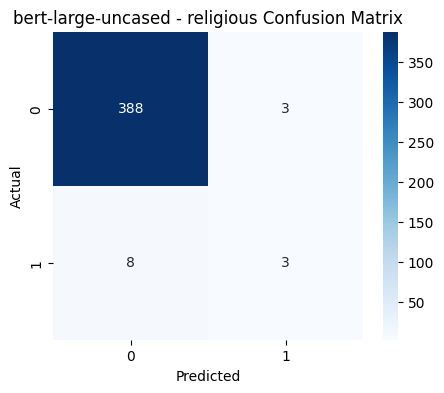

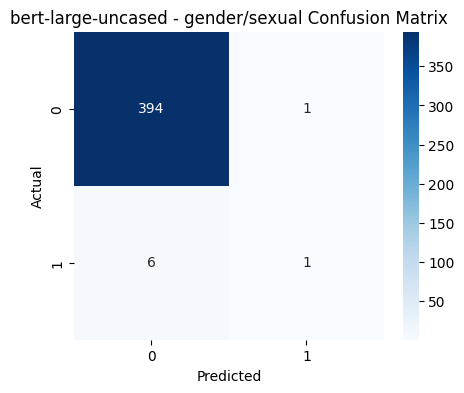

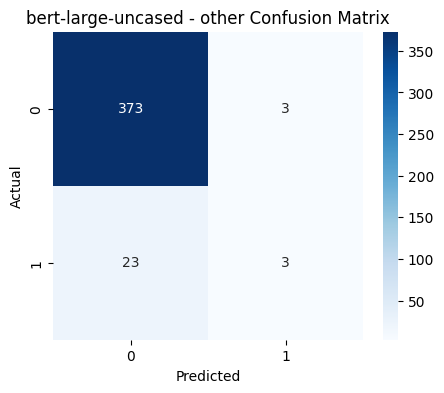

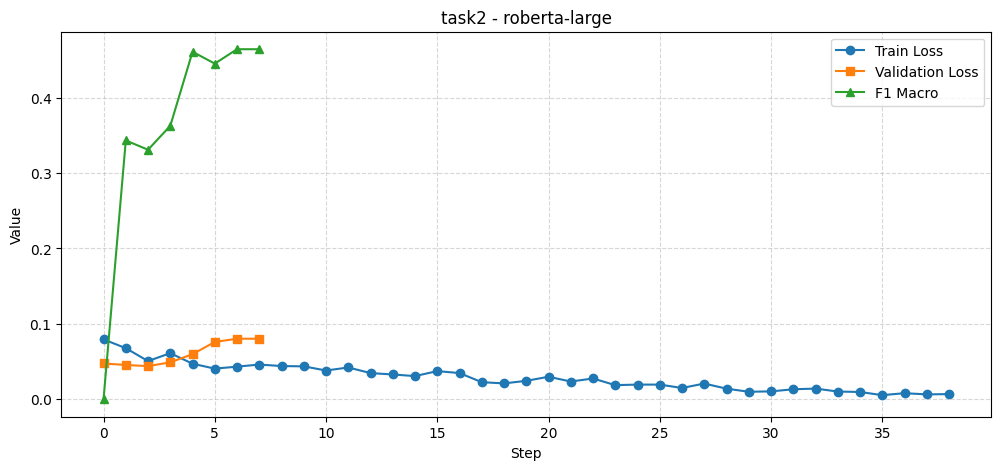

<Figure size 640x480 with 0 Axes>

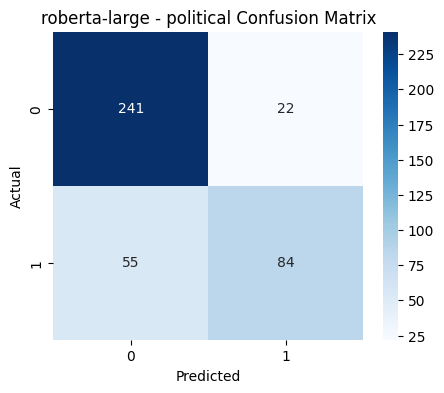

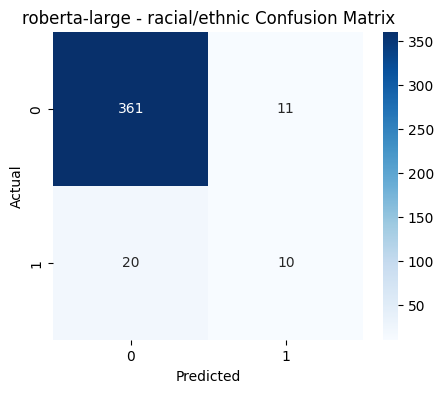

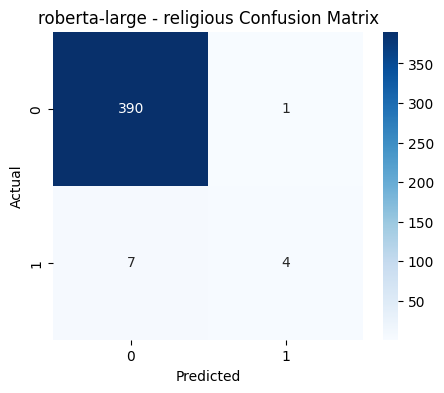

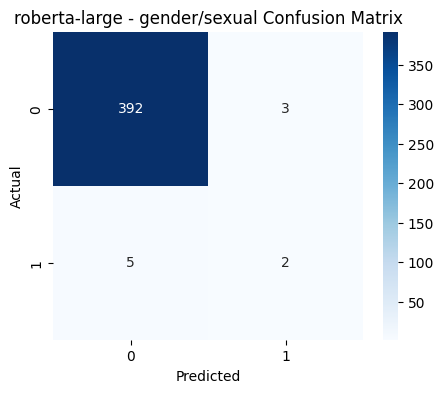

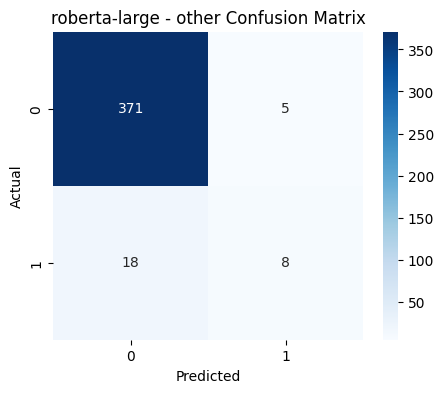


Evaluating on TEST set...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [4]:
# ---------------------------
# USAGE
# ---------------------------
# Example: Task 2, ensemble of BERT and RoBERTa, focal loss, early stopping
trainer_obj = PolarizationTrainer(
    csv_path="eng.csv",
    task="task2",
    model_names=["bert-large-uncased", "roberta-large"],
    criterion="focal",
    early_stop=True,
    patience=2,
    max_epochs=7,
    #ensemble=True,
    test_csv_path="test_eng.csv",
)

trainers, eval_results = trainer_obj.run()

In [7]:
# Source - https://stackoverflow.com/a
# Posted by Shashank Mishra
# Retrieved 2026-01-22, License - CC BY-SA 4.0

!zip -r saved_models_task_1.zip /content/saved_models


  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/roberta-large_task1/ (stored 0%)
  adding: content/saved_models/roberta-large_task1/special_tokens_map.json (deflated 52%)
  adding: content/saved_models/roberta-large_task1/tokenizer_config.json (deflated 75%)
  adding: content/saved_models/roberta-large_task1/tokenizer.json (deflated 82%)
  adding: content/saved_models/roberta-large_task1/merges.txt (deflated 53%)
  adding: content/saved_models/roberta-large_task1/model.safetensors (deflated 11%)
  adding: content/saved_models/roberta-large_task1/vocab.json (deflated 59%)
  adding: content/saved_models/roberta-large_task1/training_args.bin (deflated 53%)
  adding: content/saved_models/bert-large-uncased_task1/ (stored 0%)
  adding: content/saved_models/bert-large-uncased_task1/special_tokens_map.json (deflated 42%)
  adding: content/saved_models/bert-large-uncased_task1/tokenizer_config.json (deflated 75%)
  adding: content/saved_models/bert-large-uncased_task

In [8]:
from google.colab import drive
import shutil

# 1. Mount Drive (Standard method)
drive.mount('/content/drive')

# 2. Copy the ZIP file you just created to your Drive
# This assumes your zip is named 'saved_models.zip' and is in /content/
source_path = "/content/saved_models_task_1.zip"
destination_path = "/content/drive/MyDrive/saved_models_task_1.zip"

print(f"Copying {source_path} to Google Drive...")
shutil.copy(source_path, destination_path)
print(f"Success! Go to https://drive.google.com and download 'saved_models.zip' from there.")

Mounted at /content/drive
Copying /content/saved_models_task_1.zip to Google Drive...
Success! Go to https://drive.google.com and download 'saved_models.zip' from there.


In [9]:
from google.colab import files
files.download('saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Device: cuda

Training bert-large-uncased for task1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.132100,0.110039,0.788421
2,0.096100,0.107352,0.812305
3,0.048200,0.152782,0.811483
4,0.027800,0.237204,0.798628



Training roberta-large for task1...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.155000,0.114157,0.817106
2,0.121100,0.103744,0.820325
3,0.081900,0.110364,0.825980
4,0.063700,0.185951,0.845571
5,0.049900,0.225250,0.830684
6,0.021800,0.282897,0.822779


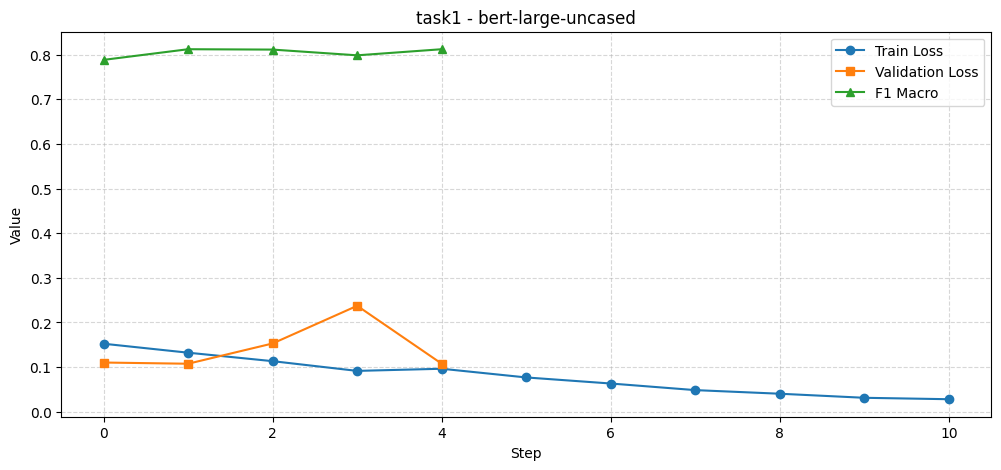

<Figure size 640x480 with 0 Axes>

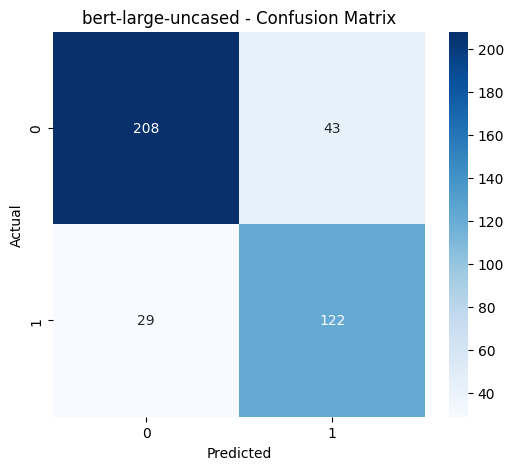

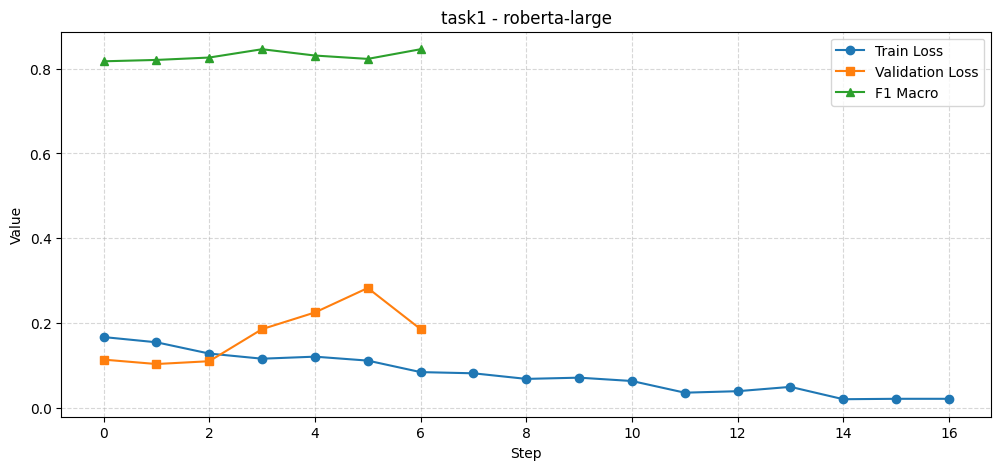

<Figure size 640x480 with 0 Axes>

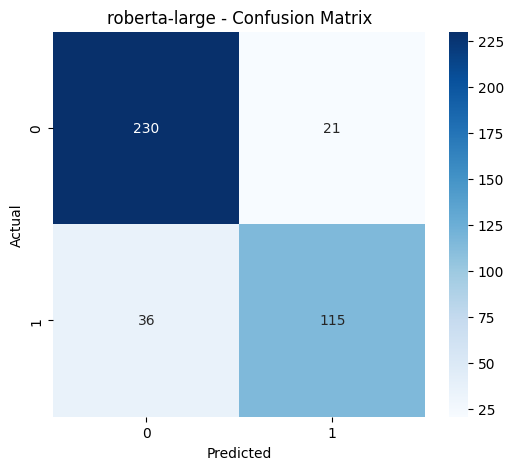

In [6]:
# ---------------------------
# USAGE
# ---------------------------
# Example: Task 2, ensemble of BERT and RoBERTa, focal loss, early stopping
trainer_obj = PolarizationTrainer(
    csv_path="eng.csv",
    task="task1",
    model_names=["bert-large-uncased", "roberta-large"],
    criterion="focal",
    early_stop=True,
    patience=2,
    max_epochs=7,
    #ensemble=True,
    #test_csv_path="test_eng.csv",
)

trainers, eval_results = trainer_obj.run()